In [1]:

import sys
sys.path.append("..")
from BacktestApp import BacktestApp
from utils import vwap, is_within_specific_minutes_of_close
from PositionManagerPlus import PositionManager

import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
import scipy.optimize as optimize
import matplotlib.pyplot as plt

def find_pivot_point(bars, ema_column='ema_10'):
    df = bars.copy()
    df['slope'] = df[ema_column].diff()  # 计算斜率
    df['sign_change'] = (df['slope'] * df['slope'].shift(1) < 0)  # 斜率变号，标记拐点
    pivot_df = df[df['sign_change']].copy()  # 提取所有拐点

    if pivot_df.empty:
        return bars  # 没有拐点直接返回

    # **第一步：筛选局部高低点**
    valid_pivots = [pivot_df.index[0]]  # 先保留第一个拐点
    for i in range(1, len(pivot_df) - 1):  # 遍历所有拐点（忽略首尾）
        idx = pivot_df.index[i]
        prev_idx, next_idx = pivot_df.index[i - 1], pivot_df.index[i + 1]

        # 仅保留局部最高点或最低点
        if (df.loc[idx, ema_column] > df.loc[prev_idx, ema_column] and 
            df.loc[idx, ema_column] > df.loc[next_idx, ema_column]) or \
           (df.loc[idx, ema_column] < df.loc[prev_idx, ema_column] and 
            df.loc[idx, ema_column] < df.loc[next_idx, ema_column]):
            valid_pivots.append(idx)
    valid_pivots.append(pivot_df.index[-1])  # 保留最后一个拐点
    bars["pivot"] = False
    bars.loc[valid_pivots, "pivot"] = True

    return bars

def fit_piecewise_segments(df, x_col, y_col, count, plot=False, highlight=None):
    """
    使用分段拟合对数据进行 Piecewise Regression (支持时间作为 X 轴)

    参数:
    - df: pd.DataFrame, 需要包含 x_col 和 y_col 两列
    - x_col: str, 作为 X 轴的列名 (如果是时间列，会自动转换为数值)
    - y_col: str, 作为 Y 轴的列名
    - count: int, 需要分的段数

    返回:
    - px: np.ndarray, 分段的 x 轴坐标（原始时间格式）
    - py: np.ndarray, 分段的 y 轴坐标
    """
    # 转换时间列为数值（时间戳 -> 秒级浮点数）
    X = pd.to_datetime(df[x_col]).astype(np.int64) / 1e9  # 转换为秒
    Y = df[y_col].values

    xmin = X.min()
    xmax = X.max()

    # 计算初始分段点
    seg = np.full(count - 1, (xmax - xmin) / count)
    px_init = np.r_[np.r_[xmin, seg].cumsum(), xmax]
    py_init = np.array([Y[np.abs(X - x) < (xmax - xmin) * 0.01].mean() for x in px_init])

    def func(p):
        seg = p[:count - 1]
        py = p[count - 1:]
        px = np.r_[np.r_[xmin, seg].cumsum(), xmax]
        return px, py

    def err(p):
        px, py = func(p)
        Y2 = np.interp(X, px, py)
        return np.mean((Y - Y2) ** 2)

    r = optimize.minimize(err, x0=np.r_[seg, py_init], method='Nelder-Mead')

    # 将 px 转回时间格式
    px, py = func(r.x)
    px = pd.to_datetime(px * 1e9)  # 秒 -> 纳秒时间戳
    slope = (py[1] - py[0]) / py[0] * 1000
    if plot:
        plt.plot(df[x_col], df[y_col], ".")
        plt.plot(px, py, "-or")
        if highlight:
            # 找到对应的 y 值
            highlight_y = df.loc[df[x_col] == highlight, y_col].values[0]  # 获取对应的 y 值
            # 标红该点
            plt.scatter(highlight, highlight_y, color='red', s=80, zorder=3)
    return slope

class Trend:
    def __init__(self, contract, pm:PositionManager):
        self.contract = contract
        self.pm = pm
        
        self.vwap_slope_threhold = 0.07
        self.close_pct_change_threhold = 0.07
        self.ampitude_range = []
        self.debug_slice = []
        self.post_buy_pattern = None
        self.open_position_df = None
        
    def calculate_open_amount(self, bars):
        if self.pm.net_liquidation is None or self.pm.available_funds is None:
            print("PositionManager.calculate_open_amount net_liquidation or available_funds is None")
            return 0
        
        target_market_value = self.pm.net_liquidation * 0.5
        if target_market_value > self.pm.available_funds: return 0
        
        open_amount = target_market_value / bars.iloc[-1]['close']
        open_amount = round(open_amount / 10) * 10  # 调整为 10 的倍数
        return int(open_amount)

    def find_position(self):
        is_match = lambda item: (
            item["contract"] == self.contract and
            item["strategy"] == "Trend"
        )
        return self.pm.find_position(is_match)
    
    def setParams(self, bars, window=60, close_amplitude_threshold=0.005, debug=True):
        # if len(bars) < window: return
        bars['ema_10'] = bars['close'].ewm(span=10, adjust=False).mean()        
        bars['range_max'] = bars["close"].rolling(window=window).max()
        bars['range_min'] = bars["close"].rolling(window=window).min()
        bars['range_pct'] = (bars['range_max'] - bars['range_min']) / bars['range_min']
        bars['prev_window_ema_10'] = bars['ema_10'].shift(window)
        bars['ema_10_diff_window_begin'] = (bars['prev_window_ema_10'] - bars['ema_10']) / bars['ema_10']
        # bars['sideways_market'] = bars['range_pct'] < close_amplitude_threshold
        bars = find_pivot_point(bars)
        if debug:        
            bars['slope'] = np.nan
            index = 0
            while index < len(bars):
                if index < 59: 
                    index += 1
                    continue
                df = bars.iloc[index - window + 1 : index + 1]
                bars.at[index, 'slope'] = fit_piecewise_segments(df, "date", "ema_10", count=1)
                index += 1

        return bars
    
    def get_open_signal(self, bars):
        if len(self.ampitude_range) == 0: return None
        signal = None
        compare_ampitude_range = None
        # 当前bars最新一根行情是震荡，且前一根也是震荡的情况
        # 其实当前区域突破了前一个震荡区间，增加判定以使用前一个震荡区间的值
        if self.ampitude_range[-1].iloc[-1]["date"] == bars.iloc[-1]["date"]:
            if len(self.ampitude_range) > 1:
                compare_ampitude_range = self.ampitude_range[-2]
        else:
            compare_ampitude_range = self.ampitude_range[-1]
            
        if compare_ampitude_range is not None:
            if bars.iloc[-1]["date"] - compare_ampitude_range.iloc[-1]["date"] > pd.Timedelta(minutes=20):
                return None
            if bars.iloc[-1]["close"] > compare_ampitude_range["close"].max():
                return "做多"
            if bars.iloc[-1]["close"] < compare_ampitude_range["close"].min():
                return "做空"
        return signal
    
    def get_close_signal(self, position, bars):
        """
        返回格式 减仓比例, 减仓原因
        减仓条件：
        1. 开仓后价格直接回到成交时的区间中轨，平仓（强制）
        2. 从最高点回落一半,平半仓（假突破）,回落到开仓价位以下时，再平半仓
        3. 如果走出单边走势,破ema10, 区间长度需要超过10分钟(止盈)
        """
        amount = position["amount"]
        
        ## 条件一
        middle_price = (self.open_position_df["close"].max() + self.open_position_df["close"].min()) / 2
        if (bars.iloc[-1]["close"] < middle_price and amount > 0) or \
            (bars.iloc[-1]["close"] > middle_price and amount < 0):
                print(f'开仓时的时间点{self.open_position_df.iloc[0]["date"]}-{self.open_position_df.iloc[-1]["date"]} 中枢价格{middle_price} 当前价格{bars.iloc[-1]["close"]}')
                return 1, f"价格回落开仓区间中枢"
        
        ## 条件二
        df = bars[bars["date"] >= position["date"]]
        
        drawdown_ratio = 0.5
        max_profit_price = df["close"].min() if amount < 0 else df["close"].max()
        init_price = df.iloc[0]["close"]
        current_price = df.iloc[-1]["close"]
        # 区域限定的mask
        mask = (max_profit_price > current_price > init_price and amount > 0) or \
                (max_profit_price < current_price < init_price and amount < 0)
        # 回落比例 = (max_profit_price - current_price) / (max_profit_price - current_price)
        if len(df) > 3 \
            and (max_profit_price - init_price) != 0 \
            and (max_profit_price - current_price) / (max_profit_price - init_price) >= drawdown_ratio \
            and mask \
            and abs((current_price - init_price) / init_price) >= 0.002 \
            and position["amount"] == position["init_amount"]:
                self.post_buy_pattern = "回落走势"
                return 0.5, f"从最高点回落超过{drawdown_ratio}"
            
        if self.post_buy_pattern == "回落走势" \
            and ((current_price < init_price and amount > 0) or (current_price > init_price and amount < 0)):
            return 0.5, f"从最高点回落超过{drawdown_ratio}"

    def combine_trend_pivot(self, df):
        def filter_pivots(index_array, ema_array, min_pivots=4):
            """
            递归过滤有效拐点，直到没有点满足震荡条件，或者剩余点数小于 `min_pivots`
            
            :param index_array: 拐点索引的 numpy 数组
            :param ema_array: EMA 值的 numpy 数组
            :param min_pivots: 终止递归的最小拐点数（默认 4）
            :return: 过滤后的 (index_array, ema_array)
            """
            if len(index_array) < min_pivots:
                return index_array, ema_array  # 剩余点不足，直接返回
            final_indices = [index_array[0]]  # 先保留第一个拐点
            i = 1
            while i < len(index_array) - 2:  # 需要至少 4 个点才能判断震荡
                ema1, ema2, ema3, ema4 = ema_array[i - 1], ema_array[i], ema_array[i + 1], ema_array[i + 2]
                if (ema1 < ema3 < ema2 < ema4) or (ema1 > ema3 > ema2 > ema4):  # 震荡上升/下降
                    i += 2  # 跳过 idx2 和 idx3
                else:
                    final_indices.append(index_array[i])  # 保留当前点
                    i += 1  # 继续下一个点

            # **保留最后一个点**
            if index_array[-1] not in final_indices:
                final_indices.append(index_array[-1])

            final_indices = np.array(final_indices)
            final_ema_values = ema_array[np.isin(index_array, final_indices)]  # 只保留筛选后的 ema
            # return final_indices, final_ema_values
            if len(final_indices) == len(index_array):
                return final_indices, final_ema_values

            return filter_pivots(final_indices, final_ema_values, min_pivots)
    
        df = df.copy()
        df.loc[df.index[0], "pivot"] = True
        df.loc[df.index[-1], "pivot"] = True
        pivot_df = df[df["pivot"] == True]
        # print(pivot_df)
        index_array = np.array(pivot_df.index)
        ema_array = df.loc[index_array, 'ema_10'].to_numpy()
        filtered_indices, filtered_ema = filter_pivots(index_array, ema_array, min_pivots=4)
        return df.loc[filtered_indices]
    
    def update(self, bars):
        if len(bars) < 60: return
        # bars = self.setParams(bars, debug=False)
        df_slice = bars.iloc[-60:]
        if bars.iloc[-1]["range_pct"] < 0.005 and \
            abs(bars.iloc[-1]["slope"]) <= 1 and \
            abs(bars.iloc[-1]["ema_10_diff_window_begin"]) < 0.001:
            self.ampitude_range.append(df_slice)
        
        # 反手信号（平仓部分）
        position = self.find_position()
        open_single = self.get_open_signal(bars)
        if open_single:
            direction = 1 if open_single == "做多" else -1
            if position and direction * position["amount"] < 0:
                self.pm.close_position(position, bars)
                self.open_position_df = None
        
        # 开仓信号
        position = self.find_position()
        if open_single and not position and not is_within_specific_minutes_of_close(bars, 60):
            direction = 1 if open_single == "做多" else -1
            amount = direction * self.calculate_open_amount(bars)
            self.pm.open_position(self.contract, "Trend", amount, bars)
            self.open_position_df = df_slice
            self.debug_slice.append({
                "df": self.ampitude_range[-1],
                "date": bars.iloc[-1]["date"],
                "index": bars.iloc[-1].name
            })
        
        # 收盘前平仓
        position = self.find_position()
        if position and is_within_specific_minutes_of_close(bars, 5):
            self.pm.close_position(position, bars)
        
        # 常规止盈止损
        position = self.find_position()
        if position:
            close_signal = self.get_close_signal(position, bars)
            if close_signal:
                close_pct, reason = close_signal
                substract_amount = position["init_amount"] * close_pct
                if (substract_amount < position["amount"] and substract_amount > 0) or \
                    (substract_amount > position["amount"] and substract_amount < 0):
                    self.pm.substract_position(position, close_pct, bars, reason=reason)
                else:
                    self.pm.close_position(position, bars, reason=reason)
                    self.open_position_df = None
                    
class TrendBacktestApp(BacktestApp):
    def __init__(self, config_file="config.yml", **kwargs):
        super().__init__(config_file, **kwargs)
        self.trend = { contract.symbol: Trend(contract, self.pm) for contract in self.contracts }
        
    def on_bar_update(self, contract, bars, has_new_bar):
        bars = bars.copy()
        self.trend[contract.symbol].update(bars)

try:
    ba = TrendBacktestApp(config_file="../config_backtest.yml", clientId=20, debug=True, autoConnect=False)
    end_date = "2025-02-24"
    duration_str = "200 D"
    # ba.minutes_backtest(end_date, duration_str, pre_process_bar_callback=ba.trend[ba.contracts[0].symbol].setParams)
finally:
    if ba.ib:
        ba.ib.disconnect()

19 2024-06-04


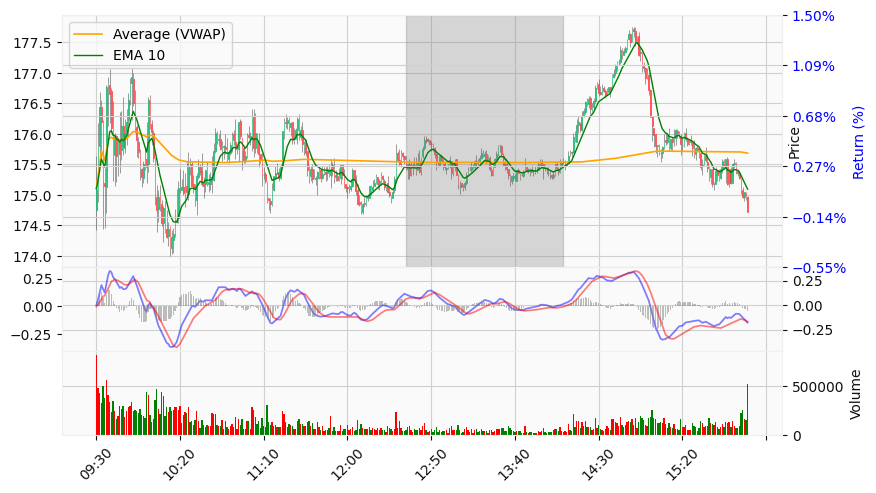

In [22]:
from PlotPlus import PlotPlus
# idx = 0
while True:
    daily = ba.get_historical_data(ba.contracts[0], end_date, duration_str, '1 day')
    date = daily.iloc[idx]['date']
    print(idx, date)
    idx += 1
    df = ba.get_historical_data(ba.contracts[0], date)
    st = Trend(ba.contracts[0], ba.pm)
    df = st.setParams(df, window=60)
    
    df["slope_segment"] = False
    low_slope_indices = df.index[(df["slope"].abs() < 1) & (df["range_pct"] < 0.005) & (df["ema_10_diff_window_begin"].abs() < 0.001)]
    for o_idx in low_slope_indices:
        df.loc[max(0, o_idx - 59): o_idx, "slope_segment"] = True
        
    pp = PlotPlus(df)
    pp.plot_basic(style_type="candle")
    pp.mark_segment("slope_segment")
    # pivot_point = df[df["pivot"]]
    # pp.mark_point(pivot_point, "ema_10")
    pp.mark_bs_point(ba.pm.trade_log)
    pp.show()
    
    break

In [112]:
for n_idx, row in df.iterrows():
    df_slice = df.loc[:n_idx].copy()
    st.update(df_slice)

【2024-11-08 11:24:00-05:00】【Trend】开仓: AMZN, 价格: 209.06, 数量：480, 浮动盈亏：None
【2024-11-08 13:22:00-05:00】【Trend】平仓: AMZN, 价格: 208.91, 数量：-480, 浮动盈亏：-72.00000000000273
【2024-11-08 13:22:00-05:00】【Trend】开仓: AMZN, 价格: 208.91, 数量：-480, 浮动盈亏：None
【2024-11-08 15:55:00-05:00】【Trend】平仓: AMZN, 价格: 207.73, 数量：480, 浮动盈亏：566.4000000000033


(295,
 Timestamp('2024-10-07 14:25:00-0400', tz='US/Eastern'),
 Timestamp('2024-10-07 14:25:00-0400', tz='US/Eastern'),
 np.float64(181.36))

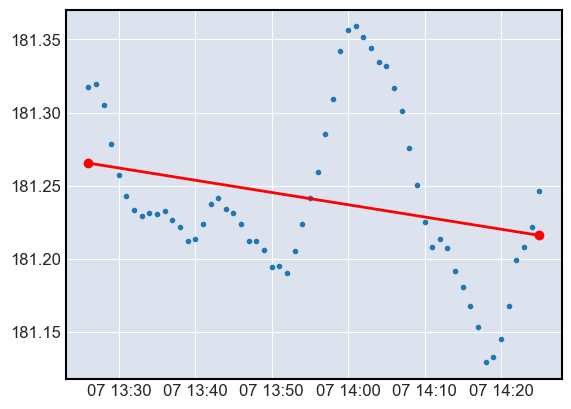

In [83]:
st_debug_idx = 3
item = st.debug_slice[st_debug_idx]
slope = fit_piecewise_segments(item["df"], "date", "ema_10", count=1, plot=True)
# item["df"].iloc[-1]["range_pct"], item["df"].iloc[-1]["slope"], item["df"].iloc[-1]["ema_10_diff_window_begin"]
item["index"], item["date"], item["df"].iloc[-1]["date"], item["df"].iloc[-1]["close"]

In [17]:
def split_sideways_market(df, column, remain=50):
    df = df.copy().reset_index()
    df['future_max'] = df[column].iloc[::-1].cummax().iloc[::-1].shift(-1)
    df['future_min'] = df[column].iloc[::-1].cummin().iloc[::-1].shift(-1)
    # 计算剩余行数：假设 df 的默认索引从 0 开始
    n = len(df)
    df['remaining'] = n - df.index
    # print(df[['ema_10', 'future_max', 'future_min', 'remaining']])

    # 筛选满足条件的行：
    # 当前行的 close 大于之后所有收盘价（即 > future_max），或者小于之后所有收盘价（即 < future_min），
    # 同时剩余行数大于 90。
    condition = ((df[column] > df['future_max']) | (df[column] < df['future_min'])) & (df['remaining'] > remain)
    result = df[condition]

    if not result.empty:
        print(result.iloc[-1]["date"])
        return result.iloc[-1]
    else:
        print("未找到满足条件的行。")

2024-05-14 15:05:00-04:00
n_idx is 390
True False True
91.46760725374034 91.38


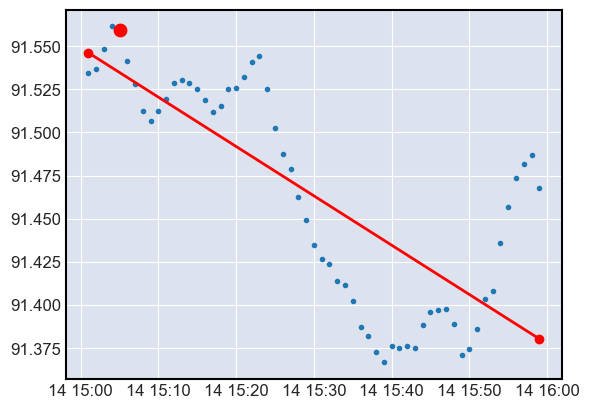

In [31]:
n_idx = 390

while True:
    df_slice = df.iloc[n_idx - 60 + 1 : n_idx + 1]
    split_row = split_sideways_market(df_slice, 'ema_10', remain=50)
    date = None if split_row is None else split_row["date"]
    slope = fit_piecewise_segments(df_slice, "date", "ema_10", count=1, plot=True, highlight=date)
    print(f"n_idx is {n_idx}")
    print(df_slice.iloc[-1]["range_pct"] < 0.005, abs(df_slice.iloc[-1]["slope"]) <= 1, abs(df_slice.iloc[-1]["ema_10_diff_window_begin"]) < 0.001)
    print(df_slice.iloc[-1]["ema_10"], df_slice.iloc[-1]["close"])
    n_idx += 5
    break
    if n_idx > 389: break

64 2024-08-08


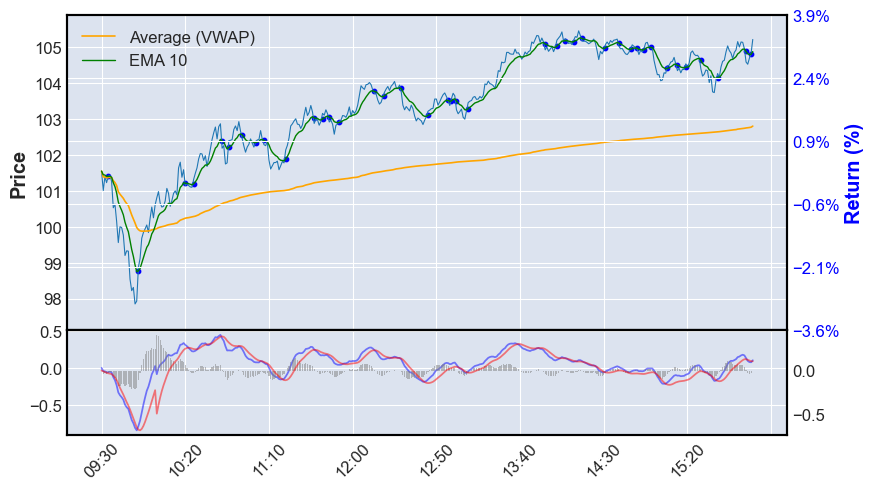

Empty DataFrame
Columns: [date, symbol, strategy, open_or_close, direction, price, amount, commission, pnl, reason]
Index: []


In [46]:
from PlotPlus import PlotPlus
# idx = 50
while True:
    # history = pd.DataFrame(ba.pm.trade_log)
    daily = ba.get_historical_data(ba.contracts[0], end_date, duration_str, '1 day')
    date = daily.iloc[idx]['date']
    print(idx, date)
    idx += 1
    df = ba.get_historical_data(ba.contracts[0], date)
    st = Trend(ba.contracts[0], ba.pm)
    df = st.setParams(df, window=60)
    
    pp = PlotPlus(df)
    pp.plot_basic()
    # pp.mark_segment("sideways_market")
    pivot_point = df[df["pivot"]]
    pp.mark_point(pivot_point, "ema_10")
    pp.mark_bs_point(ba.pm.trade_log)
    pp.show()
    history = pd.DataFrame(ba.pm.trade_log)
    print(history[history["date"].dt.date == date])
    
    break

114
4.636990150614451


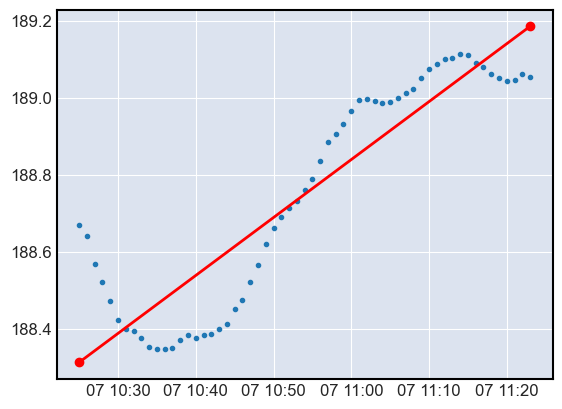

In [1579]:
df_copy = pp.df.copy().reset_index(drop=True)
indices = df_copy[df_copy['signal'].notna()].index
n_idx = 0
while True:
    i = indices[n_idx]
    print(i)
    df_slice = df_copy.iloc[i - 59: i]
    slope = fit_piecewise_segments(df_slice, "date", "ema_10", count=1, plot=True)
    print(slope)
    n_idx += 1
    break

In [62]:
ba.statistic()

{'cumulative_pnl': np.float64(9651.107528000022),
 'max_drawdown': np.float64(0.011057069496127402),
 'sharpe_ratio': np.float64(-0.7161925129976413),
 'volatility': np.float64(0.02705129947295641),
 'daily_return': np.float64(6.200818194687135e-05),
 'commission': np.float64(11094.751804000001)}

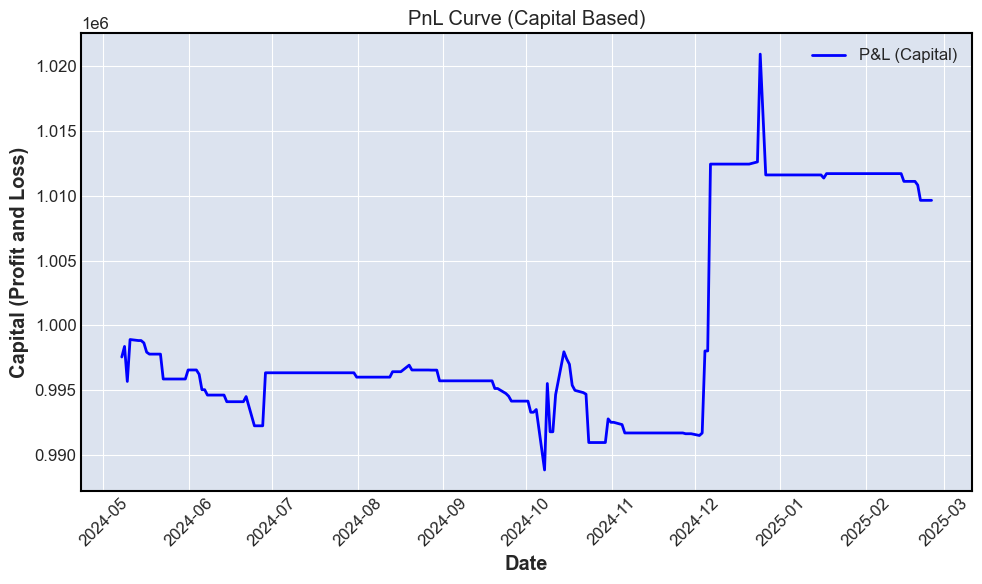

In [63]:
ba.plot_pnl()

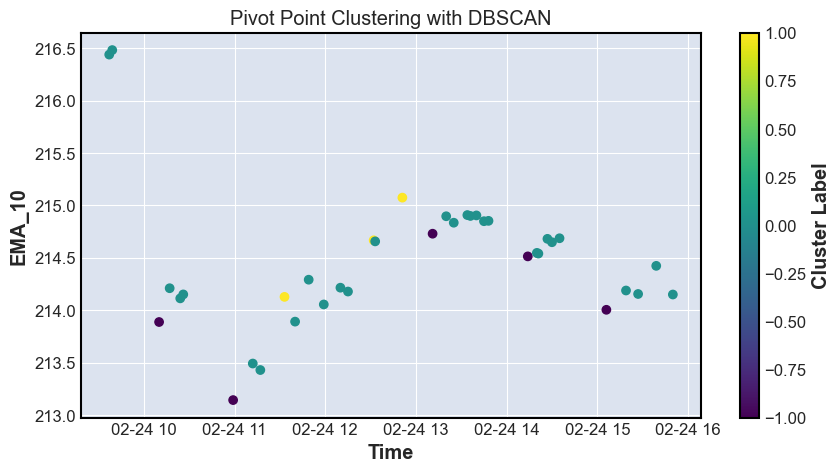

In [564]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

def cluster_pivots(pivot_df, eps=0.5, min_samples=2):
    pivot_df = pivot_df.copy()
    # 计算时间间隔（转换为分钟）和价格间隔
    pivot_df = pivot_df.sort_index()
    pivot_df['time_diff'] = pivot_df.index.to_series().diff().dt.total_seconds() / 60  # 时间间隔（分钟）
    pivot_df['price_diff'] = pivot_df['ema_10'].diff()  # 价格间隔
    
    # 需要删除 NaN（首个点没有时间间隔 & 价格间隔）
    pivot_df = pivot_df.dropna(subset=['time_diff', "price_diff"])
    # 归一化时间和价格间隔
    pivot_df['time_diff_scaled'] = (pivot_df['time_diff'] - pivot_df['time_diff'].mean()) / pivot_df['time_diff'].std()
    pivot_df['price_diff_scaled'] = (pivot_df['price_diff'] - pivot_df['price_diff'].mean()) / pivot_df['price_diff'].std()

    # 选择特征进行聚类（时间间隔 & 价格间隔）
    features = pivot_df[['time_diff_scaled', 'price_diff_scaled']].values
    
    # 进行 DBSCAN 聚类
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    pivot_df['cluster'] = dbscan.fit_predict(features)  # -1 表示离群点

    return pivot_df

# 运行聚类分析
df = df.set_index("date", drop=False)
pivot_clustered = cluster_pivots(df[df["pivot"]])

# 可视化聚类结果
plt.figure(figsize=(10, 5))
plt.scatter(pivot_clustered.index, pivot_clustered['ema_10'], c=pivot_clustered['cluster'], cmap='viridis', marker='o')
plt.colorbar(label='Cluster Label')
plt.xlabel('Time')
plt.title('Pivot Point Clustering with DBSCAN')
plt.ylabel('EMA_10')
plt.show()


In [1]:
pd.DataFrame(ba.pm.trade_log).head(30)

NameError: name 'pd' is not defined